In [3]:

import optuna
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
import joblib
import seaborn as sns
import os
import gc
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.utils import indexable
from sklearn.utils.validation import _num_samples
from sklearn.model_selection._split import _BaseKFold
from optuna.integration import LightGBMPruningCallback
from optuna.visualization import plot_contour
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
import warnings
warnings.filterwarnings("ignore")


This notebook is for dealing with stock prices of Japanese companies.

Import data which is standarlized and extreme value removed.

In [21]:
prices = pd.read_csv('/Users/dylan/iCollections/桌面文件/jpx-tokyo-stock-exchange-prediction/reduced_train_files/reduced_stock_prices_std_outlier.csv')

In [23]:
prices.Date = pd.to_datetime(prices.Date)
prices['Date'] = prices['Date'].dt.strftime("%Y%m%d").astype(int)


In [25]:
train_x = prices[['Date', 'Open', 'Close', 'High', 'Low', 'SecuritiesCode', 'Volume']]
groups = prices[['SecuritiesCode']]
train_y = prices[['Target']]

In [7]:
# self defined GroupTimeSeriesSplit
class GroupTimeSeriesSplit(_BaseKFold):

    def __init__(self, n_splits=5, *, max_train_size=None):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_size = max_train_size

    def split(self, X, y=None, groups=None):

        n_splits = self.n_splits
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_folds = n_splits + 1
        indices = np.arange(n_samples)
        group_counts = np.unique(groups, return_counts=True)[1]
        groups = np.split(indices, np.cumsum(group_counts)[:-1])
        n_groups = _num_samples(groups)
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds ={0} greater"
                 " than the number of groups: {1}.").format(n_folds, n_groups))
        test_size = (n_groups // n_folds)
        test_starts = range(test_size + n_groups % n_folds,
                            n_groups, test_size)
        for test_start in test_starts:
            if self.max_train_size:
                train_start = np.searchsorted(
                    np.cumsum(
                        group_counts[:test_start][::-1])[::-1] < self.max_train_size + 1, 
                        True)
                yield (np.concatenate(groups[train_start:test_start]),
                       np.concatenate(groups[test_start:test_start + test_size]))
            else:
                yield (np.concatenate(groups[:test_start]),
                       np.concatenate(groups[test_start:test_start + test_size]))

In [26]:
# optuna parameters 
def Objective(trial,X,y,groups):
    params_grid = {
        'objective' : 'regression',
        'metric':'l2',
        'num_leaves': trial.suggest_int('num_leaves', 300, 4000),
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'max_bin': trial.suggest_int('max_bin', 2, 100),
        # 'max_deepth': trial.suggest_int('max_deepth', )
    }
    
    pruning = LightGBMPruningCallback(trial, 'l2')
    cv_score = np.empty(5)
    
    gpcv = GroupTimeSeriesSplit()
    for index, (train_idx, val_idx) in enumerate(gpcv.split(X, groups=groups)):
        train_x, train_y = X.iloc[train_idx, :], y.iloc[train_idx, :]
        val_x, val_y = X.iloc[val_idx, :], y.iloc[val_idx, :]
        lgb_train = lgb.Dataset(train_x, label=train_y)
        lgb_validation = lgb.Dataset(val_x, label=val_y)
        model_lightgbm = lgb.train(params_grid, train_set=lgb_train, valid_sets=[lgb_validation], 
                                , early_stopping_rounds=100, callbacks=[pruning])
        model_predict = model_lightgbm.predict(val_x)
        cv_score[index] = mean_squared_error(model_predict, val_y)
        del train_x, val_x, train_y, val_y
    
    return np.mean(cv_score)

In [27]:
study = optuna.create_study(direction='minimize', study_name='LGBM Regression')
func = lambda trial : Objective(trial, train_x, train_y, groups)
study.optimize(func, n_trials=100)

[I 2022-04-21 16:40:27,180] A new study created in memory with name: LGBM Regression


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004214 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 84
[LightGBM] [Info] Number of data points in the train set: 397443, number of used features: 7
[LightGBM] [Info] Start training from score 0.001189


KeyboardInterrupt: 

In [ ]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

In [ ]:
# LGBM baseline
def lgbm_model(train_x, train_y, validation_x, validation_y,index):
    params_grid = {
        "objective" : "regression",
        'metric' : ['rmse']
    }

    lgb_train = lgb.Dataset(train_x, label=train_y)
    lgb_validation = lgb.Dataset(validation_x, label=validation_y)
    evals_result_lgbm = {}
    
    model_lightgbm = lgb.train(params_grid, lgb_train, valid_sets=[lgb_train, lgb_validation], 
                            num_boost_round=5000, early_stopping_rounds=200, evals_result=evals_result_lgbm, verbose_eval=100)
    
    # model_lightgbm.save_model(f'model_lightgbm_{index}.txt')
    # pre_test_lightgbm = model_lightgbm.predict(test_x, num_iteration=model_lightgbm.best_iteration)
    
    
    # return pre_test_lightgbm, model_lightgbm, evals_result_lgbm
    return  model_lightgbm, evals_result_lgbm


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002849 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1739
[LightGBM] [Info] Number of data points in the train set: 387488, number of used features: 7
[LightGBM] [Info] Start training from score 0.001220
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.0174849	valid_1's rmse: 0.0223213
[200]	training's rmse: 0.0172975	valid_1's rmse: 0.022489
Early stopping, best iteration is:
[37]	training's rmse: 0.0177326	valid_1's rmse: 0.0221996


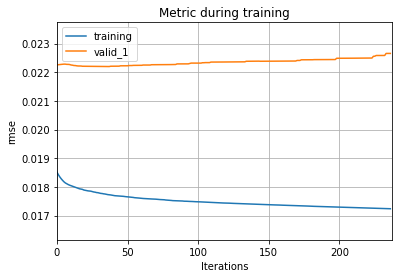

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008148 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1780
[LightGBM] [Info] Number of data points in the train set: 774975, number of used features: 7
[LightGBM] [Info] Start training from score 0.000689
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.0193906	valid_1's rmse: 0.0246902
[200]	training's rmse: 0.01925	valid_1's rmse: 0.0247419
Early stopping, best iteration is:
[1]	training's rmse: 0.0204238	valid_1's rmse: 0.0246108


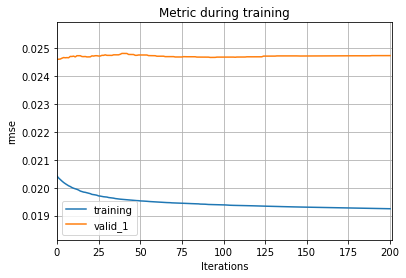

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006807 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1784
[LightGBM] [Info] Number of data points in the train set: 1162462, number of used features: 7
[LightGBM] [Info] Start training from score 0.000370
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.0208346	valid_1's rmse: 0.0279407
[200]	training's rmse: 0.0207181	valid_1's rmse: 0.0280916
Early stopping, best iteration is:
[7]	training's rmse: 0.0214768	valid_1's rmse: 0.0269663


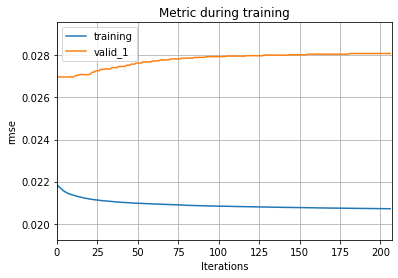

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008310 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1549949, number of used features: 7
[LightGBM] [Info] Start training from score 0.000196
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.0220676	valid_1's rmse: 0.025425
[200]	training's rmse: 0.0219545	valid_1's rmse: 0.0255498
Early stopping, best iteration is:
[41]	training's rmse: 0.0222494	valid_1's rmse: 0.0251888


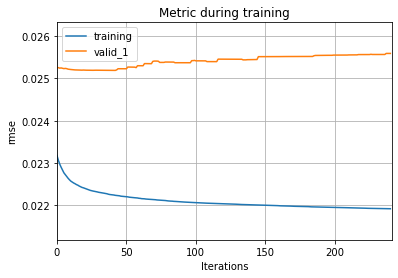

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.058500 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1785
[LightGBM] [Info] Number of data points in the train set: 1937436, number of used features: 7
[LightGBM] [Info] Start training from score 0.000454
Training until validation scores don't improve for 200 rounds
[100]	training's rmse: 0.0228232	valid_1's rmse: 0.0232786
[200]	training's rmse: 0.0227261	valid_1's rmse: 0.0234102
Early stopping, best iteration is:
[3]	training's rmse: 0.0234874	valid_1's rmse: 0.0216924


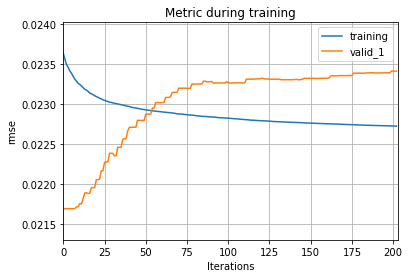

In [ ]:
cv = TimeSeriesSplit()
for index, (train_idx, val_idx) in enumerate(cv.split(train_x, train_y)):
    train_df_x, val_df_x = train_x.iloc[train_idx, :], train_x.iloc[val_idx, :]
    train_df_y, val_df_y = train_y.iloc[train_idx, :], train_y.iloc[val_idx, :]
    model_lightgbm, evals_result_lgbm = lgbm_model(train_df_x, train_df_y, val_df_x, val_df_y, index)
    del train_df_x, train_df_y, val_df_x, val_df_y
    ax = lgb.plot_metric(evals_result_lgbm, metric='rmse')
    plt.show()
    gc.collect()


## Create a test submit env

In [ ]:
## Create a test submit ev
sample_prediction = pd.read_csv('/Users/dylan/iCollections/桌面文件/jpx-tokyo-stock-exchange-prediction/example_test_files/sample_submission.csv')
sample_prediction = sample_prediction.iloc[2000:4000, :]
prices = pd.read_csv('/Users/dylan/iCollections/桌面文件/jpx-tokyo-stock-exchange-prediction/example_test_files/stock_prices.csv')
prices = prices.iloc[2000:4000, :]

In [ ]:
    prices['Date'] = pd.to_datetime(prices['Date']).dt.strftime('%Y%m%d').astype(int)
    df = prices[['Date', 'Open', 'Close', 'High', 'Low']]
    lgbm_pred = list()
    for i in range(5):
        model = lgb.Booster(model_file=f'/Users/dylan/iCollections/桌面文件/jpx-tokyo-stock-exchange-prediction/code_JPX /model_lightgbm_{i}.txt')
        prediction = model.predict(df, num_iteration=model.best_iteration)
        print(prediction)
        lgbm_pred.append(prediction)
    print(lgbm_pred)
    lgbm_pred = np.mean(lgbm_pred, axis = 0)
    print(len(lgbm_pred))
    sample_prediction['prediction'] = lgbm_pred
    print(sample_prediction)
    sample_prediction = sample_prediction.sort_values(by='prediction', ascending=False)
    print(sample_prediction)
    sample_prediction['Rank'] = np.arange(0, 2000)
    sample_prediction = sample_prediction.sort_values(by='SecuritiesCode', ascending=True)
    sample_prediction = sample_prediction.drop(columns=['prediction'])
    print(sample_prediction)
    submission = sample_prediction[['Date', 'SecuritiesCode', 'Rank']]
    print(submission)

[0.00113658 0.00114474 0.00113658 ... 0.00114059 0.00113658 0.00116665]
[0.00050441 0.0005202  0.00049077 ... 0.00051768 0.00049646 0.0005202 ]
[0.00026896 0.00028963 0.00026896 ... 0.00027767 0.00026896 0.00028719]
[1.73406878e-05 3.73772393e-05 1.73406878e-05 ... 2.18829300e-05
 1.73406878e-05 3.69163336e-05]
[0.00049902 0.00052086 0.00049559 ... 0.00050492 0.00049559 0.00052086]
[array([0.00113658, 0.00114474, 0.00113658, ..., 0.00114059, 0.00113658,
       0.00116665]), array([0.00050441, 0.0005202 , 0.00049077, ..., 0.00051768, 0.00049646,
       0.0005202 ]), array([0.00026896, 0.00028963, 0.00026896, ..., 0.00027767, 0.00026896,
       0.00028719]), array([1.73406878e-05, 3.73772393e-05, 1.73406878e-05, ...,
       2.18829300e-05, 1.73406878e-05, 3.69163336e-05]), array([0.00049902, 0.00052086, 0.00049559, ..., 0.00050492, 0.00049559,
       0.00052086])]
2000
            Date  SecuritiesCode  Rank  prediction
2000  2021-12-07            1301  1693    0.000485
2001  2021-12-07  